In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=1)
output_dir = './output_lambda=0.8'
lambda_ = 0.8

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=0.8/train.log and ./output_lambda=0.8/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.306 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.308 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.325 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.324 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.322 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.328 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.325 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.323 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.326 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.91140, accuracy: 12.015 %, lr:  0.00000, elapse: 0.322 min


  - (Validation) ppl:  8742.37646, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.27516, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8704.39059, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.35520, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8661.26123, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8760.94081, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8614.50428, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.30724, accuracy: 12.016 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8565.91168, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.83583, accuracy: 12.159 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  8516.96647, accuracy: 13.864 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.27564, accuracy: 13.393 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8463.36796, accuracy: 16.281 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.27950, accuracy: 15.131 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8406.95411, accuracy: 16.468 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.66757, accuracy: 15.925 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8361.91383, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8488.01193, accuracy: 16.341 %, lr:  0.00000, elapse: 0.321 min


  - (Validation) ppl:  8302.36179, accuracy: 17.161 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.28232, accuracy: 16.598 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8249.51126, accuracy: 17.625 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.80127, accuracy: 16.766 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8197.07699, accuracy: 17.431 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.37430, accuracy: 16.923 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8140.21596, accuracy: 17.749 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.54515, accuracy: 16.959 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  8090.47433, accuracy: 17.708 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.84774, accuracy: 17.089 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8029.60742, accuracy: 17.701 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.57146, accuracy: 16.941 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7969.94654, accuracy: 18.137 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.76681, accuracy: 17.069 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7912.84994, accuracy: 17.791 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.77539, accuracy: 17.121 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7847.01864, accuracy: 17.805 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.62774, accuracy: 17.042 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7784.76273, accuracy: 17.916 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.32110, accuracy: 17.119 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  7722.34685, accuracy: 18.234 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.64784, accuracy: 17.087 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7658.17918, accuracy: 17.396 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.66037, accuracy: 16.971 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  7589.45344, accuracy: 18.193 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.41969, accuracy: 16.996 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7521.63744, accuracy: 18.054 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.61065, accuracy: 16.863 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  7453.31639, accuracy: 17.839 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.17595, accuracy: 16.906 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7384.60504, accuracy: 18.144 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.86819, accuracy: 16.843 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7316.51129, accuracy: 18.546 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.06378, accuracy: 16.644 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  7242.46541, accuracy: 18.033 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.06925, accuracy: 16.541 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  7166.94479, accuracy: 17.313 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.78593, accuracy: 16.475 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7094.36076, accuracy: 16.170 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.21324, accuracy: 16.429 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  7017.88759, accuracy: 17.112 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.61174, accuracy: 16.522 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  6941.85190, accuracy: 17.763 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.15365, accuracy: 16.238 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  6864.70660, accuracy: 17.597 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.15890, accuracy: 16.142 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  6788.01646, accuracy: 17.784 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.87824, accuracy: 15.982 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  6711.52582, accuracy: 17.971 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.67602, accuracy: 15.944 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6630.80990, accuracy: 16.787 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.35326, accuracy: 15.817 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6551.19585, accuracy: 17.202 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.01656, accuracy: 15.796 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6471.06535, accuracy: 16.676 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.52805, accuracy: 15.667 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6390.60614, accuracy: 16.115 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6683.97715, accuracy: 15.359 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6312.47745, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.75030, accuracy: 15.074 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  6228.53866, accuracy: 16.371 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.70060, accuracy: 15.031 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6146.34617, accuracy: 16.330 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.21938, accuracy: 14.882 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6063.20083, accuracy: 15.672 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.76745, accuracy: 14.723 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5981.08802, accuracy: 15.582 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6301.96152, accuracy: 14.458 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5898.63501, accuracy: 15.769 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.53637, accuracy: 14.328 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5815.06402, accuracy: 13.719 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.35705, accuracy: 14.170 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  5732.44599, accuracy: 14.245 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.20187, accuracy: 13.916 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5648.61294, accuracy: 13.809 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.32007, accuracy: 13.727 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5566.41544, accuracy: 13.061 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.12751, accuracy: 13.432 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5482.20091, accuracy: 13.345 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.84937, accuracy: 13.327 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5398.48348, accuracy: 12.839 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.03120, accuracy: 13.149 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  5316.48167, accuracy: 12.597 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.49848, accuracy: 12.975 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5231.64938, accuracy: 12.202 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5594.94059, accuracy: 12.789 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5148.60523, accuracy: 12.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.02024, accuracy: 12.639 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5066.62983, accuracy: 12.084 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.73736, accuracy: 12.543 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4984.58272, accuracy: 12.071 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.70474, accuracy: 12.496 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4900.64703, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.49157, accuracy: 12.362 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4818.24335, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.27774, accuracy: 12.315 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4736.55126, accuracy: 12.015 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.32405, accuracy: 12.250 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  4656.52513, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.03110, accuracy: 12.160 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  4573.97411, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.28993, accuracy: 12.160 %, lr:  0.00001, elapse: 0.324 min


  - (Validation) ppl:  4493.21473, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.86956, accuracy: 12.089 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4412.21471, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.40790, accuracy: 12.097 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4333.51651, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4733.96942, accuracy: 12.058 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4254.02346, accuracy: 12.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.06050, accuracy: 12.060 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  4175.25212, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.04345, accuracy: 12.046 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  4096.24475, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.02158, accuracy: 12.032 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4019.44564, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.75960, accuracy: 12.026 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3942.80522, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.74931, accuracy: 12.022 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3865.83328, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.27702, accuracy: 12.024 %, lr:  0.00001, elapse: 0.324 min


  - (Validation) ppl:  3790.15072, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.15031, accuracy: 12.019 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  3715.29046, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4132.99947, accuracy: 12.018 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  3640.73461, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.30199, accuracy: 12.016 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  3568.85350, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.48388, accuracy: 12.016 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  3495.77963, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3915.93629, accuracy: 12.016 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3423.67680, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3844.92647, accuracy: 12.016 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3352.50516, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.57244, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3282.31933, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.57245, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3213.04219, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.56600, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3144.19703, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.08008, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3076.97266, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.42088, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3009.56420, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.23290, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  2945.93390, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.35718, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2879.42479, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.80025, accuracy: 12.015 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  2814.92357, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.32158, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2752.08609, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.79483, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2690.45118, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.09907, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2628.54217, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.07015, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  2568.84495, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.79492, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2508.39434, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.79675, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2450.25100, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.04342, accuracy: 12.015 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  2392.94653, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.07726, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2336.81788, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2747.93073, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2280.91092, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.61521, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  2226.83060, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.40046, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2173.16933, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.68919, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2121.45990, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2523.93636, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2069.96374, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.11957, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2018.02129, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.22122, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1969.49519, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2364.99794, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1920.14032, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.60852, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1872.30487, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.37900, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1824.47276, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.74253, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1778.95036, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.15443, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1734.57224, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.46592, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1689.64850, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.45259, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1646.34156, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.22856, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1604.57123, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.34626, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1563.46730, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.73758, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1523.46082, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.49474, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1483.55551, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.63421, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1444.62474, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1806.99758, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1407.41785, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.82881, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  1370.35640, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.84289, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1334.69182, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.46572, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1299.14301, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.03006, accuracy: 12.015 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  1264.89239, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.41492, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  1231.60238, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.47233, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1199.43152, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.48669, accuracy: 12.015 %, lr:  0.00002, elapse: 0.326 min


  - (Validation) ppl:  1167.30087, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.12639, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  1136.00974, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.49545, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  1105.98456, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.84194, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1076.60035, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1400.94989, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  1047.63372, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.65252, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  1019.83703, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1336.98026, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  992.71100, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.39381, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  966.14155, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.13042, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  939.99507, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.85697, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  915.27393, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.15884, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  890.40893, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.11681, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  866.64740, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.74015, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  843.16774, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.12743, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  820.77924, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.29864, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  798.97873, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.85156, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  777.57424, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.10829, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  756.83120, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.00685, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  736.61243, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.63117, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  717.20769, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.73231, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  698.22706, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.46388, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  679.69910, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.78855, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  661.76339, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.67839, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  644.43187, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.18419, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  627.55885, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.22845, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  611.26848, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.82399, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  595.41112, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  845.94694, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  579.97784, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.61786, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  565.10632, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.79277, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  550.78893, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.50170, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  536.74396, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.73078, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  523.24054, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.40324, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  510.24355, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.53006, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  497.48152, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.11849, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  485.18317, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.23130, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  473.29959, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.77249, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  461.84173, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.65733, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  450.67868, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.02593, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  439.99275, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.82986, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  429.51801, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  644.99837, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  419.48697, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.61137, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  409.67946, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.56541, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  400.26860, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  608.94813, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  391.31182, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.62278, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  382.41754, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.71389, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  373.94912, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.16417, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  365.76924, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  565.97011, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  357.91745, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.12645, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  350.24171, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.64444, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  342.97515, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.40608, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  335.84535, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.56845, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  329.08172, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.03840, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  322.44653, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.79876, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  316.13407, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.88971, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  310.06486, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.30568, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  304.22868, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.03525, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  298.64257, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.06013, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  293.28347, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.37678, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  288.18710, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.00261, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  283.25000, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.85333, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  278.52916, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  456.94986, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  273.98941, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.24105, accuracy: 12.016 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  269.57506, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.88786, accuracy: 12.018 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  265.43065, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.57727, accuracy: 12.020 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  261.56957, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.18976, accuracy: 12.049 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  257.42293, accuracy: 12.057 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.21011, accuracy: 12.078 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  253.83869, accuracy: 12.084 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.26638, accuracy: 12.107 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  250.33477, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.54160, accuracy: 12.161 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  246.36996, accuracy: 12.140 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.82510, accuracy: 12.189 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  243.41214, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.38725, accuracy: 12.225 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  239.90873, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  407.01683, accuracy: 12.290 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  236.60566, accuracy: 12.181 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.67627, accuracy: 12.281 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  233.02409, accuracy: 12.140 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.48498, accuracy: 12.344 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  230.18446, accuracy: 12.140 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.25075, accuracy: 12.340 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  226.95572, accuracy: 12.112 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.24038, accuracy: 12.388 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  224.01319, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.27786, accuracy: 12.376 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  221.33653, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.52809, accuracy: 12.396 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  218.62507, accuracy: 12.022 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.48185, accuracy: 12.404 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  216.01419, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.78839, accuracy: 12.411 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  212.63972, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  371.07709, accuracy: 12.418 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  210.41787, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.20763, accuracy: 12.538 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  208.30718, accuracy: 12.472 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.51020, accuracy: 12.649 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  205.96840, accuracy: 12.105 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  360.00263, accuracy: 12.670 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  203.61406, accuracy: 12.348 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.47442, accuracy: 12.847 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  201.43747, accuracy: 12.569 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.51114, accuracy: 13.081 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  198.59949, accuracy: 13.380 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  349.00365, accuracy: 13.291 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  195.02426, accuracy: 12.812 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.20679, accuracy: 13.548 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  193.34520, accuracy: 13.650 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.44998, accuracy: 13.975 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  189.80417, accuracy: 12.389 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  337.89588, accuracy: 14.193 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  188.43116, accuracy: 14.356 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.13769, accuracy: 14.669 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  185.68900, accuracy: 14.404 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.23130, accuracy: 14.978 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  183.76421, accuracy: 14.481 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.41343, accuracy: 15.394 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  181.44749, accuracy: 14.370 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  322.71201, accuracy: 15.796 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  178.99759, accuracy: 16.087 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  318.93876, accuracy: 16.190 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  176.23812, accuracy: 14.882 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.23933, accuracy: 16.515 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  173.92766, accuracy: 16.060 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.07737, accuracy: 17.091 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  170.64237, accuracy: 17.202 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.29363, accuracy: 17.593 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  169.24271, accuracy: 17.542 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.40315, accuracy: 18.938 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  167.08040, accuracy: 17.410 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  299.83500, accuracy: 20.228 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  163.75847, accuracy: 16.870 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  296.27485, accuracy: 22.137 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  161.65779, accuracy: 18.130 %, lr:  0.00003, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.52605, accuracy: 23.177 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  158.64662, accuracy: 24.536 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.47652, accuracy: 24.313 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  156.61244, accuracy: 23.525 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  284.95308, accuracy: 24.486 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  154.84066, accuracy: 24.675 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  281.24146, accuracy: 24.747 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  151.42499, accuracy: 24.550 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  277.63488, accuracy: 24.791 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  150.40128, accuracy: 24.855 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  273.63830, accuracy: 24.831 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  147.88515, accuracy: 24.972 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  270.11789, accuracy: 24.880 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  146.05204, accuracy: 24.979 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  266.56044, accuracy: 24.960 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  142.53882, accuracy: 24.827 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  262.94943, accuracy: 25.076 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  140.44882, accuracy: 25.208 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.19208, accuracy: 25.277 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  139.08167, accuracy: 25.464 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  255.42427, accuracy: 25.686 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  136.98765, accuracy: 26.413 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  252.12031, accuracy: 26.216 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  134.16632, accuracy: 27.749 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  248.61411, accuracy: 26.856 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  133.56006, accuracy: 28.227 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  245.17462, accuracy: 27.394 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  130.99843, accuracy: 28.165 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  241.79639, accuracy: 27.797 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  128.37620, accuracy: 28.262 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  238.25823, accuracy: 28.040 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  124.99359, accuracy: 28.359 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  234.81717, accuracy: 28.274 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  122.97112, accuracy: 28.421 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  231.52981, accuracy: 28.375 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  121.83917, accuracy: 28.580 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  228.10626, accuracy: 28.467 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  120.29146, accuracy: 28.587 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  224.67377, accuracy: 28.582 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  116.82562, accuracy: 28.663 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  221.62465, accuracy: 28.621 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  115.23933, accuracy: 28.677 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  218.33315, accuracy: 28.668 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  113.50717, accuracy: 28.670 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  215.34697, accuracy: 28.706 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  110.98695, accuracy: 28.733 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  212.78307, accuracy: 28.708 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  109.43886, accuracy: 28.733 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  209.37470, accuracy: 28.757 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  108.78190, accuracy: 28.636 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.64030, accuracy: 28.780 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  106.29365, accuracy: 28.850 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  203.52469, accuracy: 28.840 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  104.74977, accuracy: 28.830 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 264 ]


  - (Training)   ppl:  200.81015, accuracy: 28.855 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  102.58252, accuracy: 28.927 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  198.04678, accuracy: 28.926 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  100.91543, accuracy: 28.996 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.38869, accuracy: 28.903 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  99.46031, accuracy: 28.913 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  192.82005, accuracy: 28.954 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  98.33635, accuracy: 29.037 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  189.91897, accuracy: 29.001 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  96.73413, accuracy: 28.989 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  187.07913, accuracy: 29.045 %, lr:  0.00003, elapse: 0.325 min


  - (Validation) ppl:  95.44268, accuracy: 29.093 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  184.66673, accuracy: 29.068 %, lr:  0.00003, elapse: 0.325 min


  - (Validation) ppl:  94.94593, accuracy: 28.947 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  182.86749, accuracy: 29.058 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  92.02372, accuracy: 29.155 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.03717, accuracy: 29.128 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  91.03486, accuracy: 29.072 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  177.84652, accuracy: 29.135 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  89.68263, accuracy: 29.155 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  175.61653, accuracy: 29.171 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  88.04115, accuracy: 29.211 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  173.11500, accuracy: 29.228 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  87.88309, accuracy: 29.162 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  171.26843, accuracy: 29.206 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  86.11841, accuracy: 29.356 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  169.12817, accuracy: 29.261 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  84.68003, accuracy: 29.384 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  166.90897, accuracy: 29.309 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  83.06418, accuracy: 29.335 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  164.94888, accuracy: 29.365 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  82.40781, accuracy: 29.841 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  162.93265, accuracy: 29.464 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  81.18338, accuracy: 29.536 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  161.13764, accuracy: 29.522 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  80.38249, accuracy: 29.861 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  158.98499, accuracy: 29.605 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  79.56952, accuracy: 29.612 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.40698, accuracy: 29.711 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  78.08280, accuracy: 29.938 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  155.57985, accuracy: 29.793 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  77.50873, accuracy: 30.062 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  153.64417, accuracy: 29.909 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  76.31468, accuracy: 30.076 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.09798, accuracy: 29.991 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  75.33241, accuracy: 30.277 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  150.56340, accuracy: 30.043 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  74.13524, accuracy: 30.152 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.87131, accuracy: 30.130 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  73.18091, accuracy: 30.284 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.42045, accuracy: 30.192 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  72.62648, accuracy: 30.464 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.63538, accuracy: 30.298 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  71.12886, accuracy: 30.381 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  144.26373, accuracy: 30.380 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  71.11942, accuracy: 30.568 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  142.61749, accuracy: 30.468 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  70.36154, accuracy: 30.547 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.27550, accuracy: 30.565 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  68.86287, accuracy: 30.706 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  139.81023, accuracy: 30.659 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  67.86527, accuracy: 30.665 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.42001, accuracy: 30.750 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  67.54704, accuracy: 30.582 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  137.12922, accuracy: 30.910 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  66.64528, accuracy: 30.956 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  135.97123, accuracy: 30.928 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  65.72729, accuracy: 30.997 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.59773, accuracy: 31.067 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  65.42577, accuracy: 31.364 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.56340, accuracy: 31.150 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  64.64580, accuracy: 31.025 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  131.99500, accuracy: 31.265 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  63.76550, accuracy: 31.302 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  130.94887, accuracy: 31.373 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  62.93221, accuracy: 31.406 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  129.62710, accuracy: 31.503 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  62.19852, accuracy: 31.489 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  128.61088, accuracy: 31.592 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  62.00827, accuracy: 32.001 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.48766, accuracy: 31.713 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  61.85316, accuracy: 31.766 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.43409, accuracy: 31.787 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  60.43737, accuracy: 32.091 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  125.29796, accuracy: 31.911 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  60.18298, accuracy: 32.161 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.24311, accuracy: 32.027 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  59.65320, accuracy: 32.507 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.32031, accuracy: 32.081 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  59.18865, accuracy: 32.535 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  122.44543, accuracy: 32.226 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  58.94670, accuracy: 32.479 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  121.07361, accuracy: 32.352 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  58.00864, accuracy: 32.632 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  120.06921, accuracy: 32.433 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  58.16340, accuracy: 32.652 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 312 ]


  - (Training)   ppl:  119.31425, accuracy: 32.497 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  57.14773, accuracy: 32.625 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.50138, accuracy: 32.544 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  56.08217, accuracy: 32.839 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.61007, accuracy: 32.653 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  56.27557, accuracy: 32.853 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  116.77376, accuracy: 32.702 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  55.46879, accuracy: 32.874 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  115.82804, accuracy: 32.759 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  55.68977, accuracy: 32.819 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 317 ]


  - (Training)   ppl:  114.75680, accuracy: 32.886 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  54.32601, accuracy: 33.144 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.28307, accuracy: 32.901 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  53.77119, accuracy: 33.234 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  113.28251, accuracy: 32.991 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  53.43211, accuracy: 33.206 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.50047, accuracy: 33.101 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  53.62951, accuracy: 33.220 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  111.67922, accuracy: 33.155 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  52.69443, accuracy: 33.532 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  111.16932, accuracy: 33.215 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  52.54755, accuracy: 33.657 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  109.99335, accuracy: 33.397 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  51.84024, accuracy: 33.684 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  109.36594, accuracy: 33.487 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  51.56634, accuracy: 33.913 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  108.65452, accuracy: 33.546 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  50.96664, accuracy: 33.857 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.83139, accuracy: 33.676 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  50.76694, accuracy: 34.024 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  107.17442, accuracy: 33.808 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  50.04498, accuracy: 34.176 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.28991, accuracy: 33.885 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  50.06565, accuracy: 34.238 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 329 ]


  - (Training)   ppl:  105.66433, accuracy: 33.927 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  49.49166, accuracy: 34.287 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  105.14265, accuracy: 34.003 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  49.24193, accuracy: 34.453 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  104.76987, accuracy: 34.037 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  48.87064, accuracy: 34.868 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  103.66162, accuracy: 34.195 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  48.18469, accuracy: 34.806 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  102.89393, accuracy: 34.285 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  48.52003, accuracy: 34.730 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 334 ]


  - (Training)   ppl:  102.35448, accuracy: 34.308 %, lr:  0.00004, elapse: 0.336 min


  - (Validation) ppl:  47.94509, accuracy: 34.785 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 335 ]


  - (Training)   ppl:  101.49137, accuracy: 34.472 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  47.32190, accuracy: 34.979 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  101.01856, accuracy: 34.506 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  47.40433, accuracy: 35.111 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 337 ]


  - (Training)   ppl:  100.66011, accuracy: 34.498 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  46.76890, accuracy: 35.145 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  100.41752, accuracy: 34.450 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  46.30405, accuracy: 35.125 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  99.03011, accuracy: 34.693 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  46.11232, accuracy: 35.021 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.85936, accuracy: 34.663 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  46.11232, accuracy: 35.145 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 341 ]


  - (Training)   ppl:  98.37925, accuracy: 34.714 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  45.94866, accuracy: 35.042 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  97.46994, accuracy: 34.868 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  45.41371, accuracy: 35.208 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 343 ]


  - (Training)   ppl:  96.84211, accuracy: 34.972 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  44.90766, accuracy: 35.402 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  96.05907, accuracy: 35.070 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  44.92959, accuracy: 35.436 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 345 ]


  - (Training)   ppl:  95.92738, accuracy: 35.025 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  44.48178, accuracy: 35.568 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  95.30551, accuracy: 35.125 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  44.31239, accuracy: 35.783 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  94.58096, accuracy: 35.261 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  43.57571, accuracy: 35.900 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  94.15734, accuracy: 35.295 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  43.52003, accuracy: 35.963 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  93.59991, accuracy: 35.437 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  42.91348, accuracy: 36.011 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  92.97745, accuracy: 35.528 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  42.91102, accuracy: 36.080 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 351 ]


  - (Training)   ppl:  92.26630, accuracy: 35.636 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  42.49726, accuracy: 36.281 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  91.96151, accuracy: 35.634 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.53820, accuracy: 36.240 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 353 ]


  - (Training)   ppl:  91.38096, accuracy: 35.746 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  41.94950, accuracy: 36.343 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  90.70287, accuracy: 35.838 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  41.74341, accuracy: 36.226 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 355 ]


  - (Training)   ppl:  90.27193, accuracy: 35.902 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  41.78442, accuracy: 36.572 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 356 ]


  - (Training)   ppl:  89.41471, accuracy: 36.034 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  40.77585, accuracy: 36.434 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  88.99509, accuracy: 36.070 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  40.63094, accuracy: 36.676 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  88.47722, accuracy: 36.103 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  40.64902, accuracy: 36.524 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 359 ]


  - (Training)   ppl:  88.09136, accuracy: 36.051 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  40.30326, accuracy: 36.593 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  87.67415, accuracy: 36.106 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  39.67005, accuracy: 36.634 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  86.85687, accuracy: 36.278 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  39.40879, accuracy: 36.828 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  86.32008, accuracy: 36.249 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  39.28139, accuracy: 36.620 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  85.64720, accuracy: 36.375 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  38.87695, accuracy: 36.704 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  85.26378, accuracy: 36.376 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  38.67476, accuracy: 37.036 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  84.74327, accuracy: 36.387 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  38.28266, accuracy: 37.285 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  84.08758, accuracy: 36.535 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  37.88166, accuracy: 37.327 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  83.40811, accuracy: 36.744 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  37.71059, accuracy: 37.749 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  83.17442, accuracy: 36.801 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  37.39024, accuracy: 37.618 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  82.38729, accuracy: 37.007 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  37.18910, accuracy: 37.756 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  82.12287, accuracy: 37.090 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  36.98720, accuracy: 37.777 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 371 ]


  - (Training)   ppl:  81.34680, accuracy: 37.268 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  36.58905, accuracy: 37.825 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  81.05395, accuracy: 37.321 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  37.54718, accuracy: 37.389 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  80.58976, accuracy: 37.464 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  36.31893, accuracy: 37.832 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  80.37098, accuracy: 37.406 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  36.27566, accuracy: 37.715 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  79.52108, accuracy: 37.650 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  35.85534, accuracy: 38.012 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  79.12856, accuracy: 37.749 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.68318, accuracy: 38.082 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  78.53693, accuracy: 37.822 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  35.55790, accuracy: 38.158 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  78.14509, accuracy: 37.919 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.21629, accuracy: 38.026 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  77.84329, accuracy: 37.925 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.93608, accuracy: 38.179 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  77.50459, accuracy: 38.052 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.80183, accuracy: 38.435 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 381 ]


  - (Training)   ppl:  76.75825, accuracy: 38.208 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.09825, accuracy: 38.442 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 382 ]


  - (Training)   ppl:  76.31837, accuracy: 38.283 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.46552, accuracy: 38.629 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  75.98348, accuracy: 38.356 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  34.22645, accuracy: 38.795 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  75.57578, accuracy: 38.436 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  34.48864, accuracy: 38.560 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 385 ]


  - (Training)   ppl:  75.21902, accuracy: 38.489 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  33.82694, accuracy: 38.975 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  75.02374, accuracy: 38.527 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  33.44888, accuracy: 39.051 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  74.55989, accuracy: 38.611 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  33.62350, accuracy: 39.079 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 388 ]


  - (Training)   ppl:  74.08961, accuracy: 38.724 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.55436, accuracy: 39.231 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  73.72592, accuracy: 38.808 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  33.20952, accuracy: 39.467 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  73.42709, accuracy: 38.829 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  32.72852, accuracy: 39.619 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  73.05837, accuracy: 38.897 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  32.91924, accuracy: 39.536 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 392 ]


  - (Training)   ppl:  72.02177, accuracy: 39.131 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  32.63466, accuracy: 39.418 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 393 ]


  - (Training)   ppl:  71.95585, accuracy: 39.146 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  32.48037, accuracy: 39.889 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  71.67813, accuracy: 39.232 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.59472, accuracy: 39.273 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 395 ]


  - (Training)   ppl:  70.93879, accuracy: 39.373 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.11232, accuracy: 39.855 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 396 ]


  - (Training)   ppl:  70.72132, accuracy: 39.413 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.58601, accuracy: 40.048 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  70.32982, accuracy: 39.500 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.65486, accuracy: 39.993 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 398 ]


  - (Training)   ppl:  70.17285, accuracy: 39.529 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  31.43126, accuracy: 39.889 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 399 ]


  - (Training)   ppl:  69.60755, accuracy: 39.597 %, lr:  0.00004, elapse: 0.327 min


  - (Validation) ppl:  31.36242, accuracy: 40.159 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 400 ]


  - (Training)   ppl:  69.14435, accuracy: 39.743 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  31.36582, accuracy: 39.986 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  69.05306, accuracy: 39.786 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  30.64923, accuracy: 40.367 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  68.63168, accuracy: 39.870 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.82876, accuracy: 40.332 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 403 ]


  - (Training)   ppl:  68.13667, accuracy: 39.950 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  30.36810, accuracy: 40.602 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  67.70063, accuracy: 40.068 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.13698, accuracy: 40.457 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 405 ]


  - (Training)   ppl:  67.39576, accuracy: 40.130 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  30.80623, accuracy: 40.028 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 406 ]


  - (Training)   ppl:  67.11575, accuracy: 40.203 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.04023, accuracy: 40.713 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  66.95963, accuracy: 40.246 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.14386, accuracy: 40.630 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 408 ]


  - (Training)   ppl:  66.25864, accuracy: 40.397 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  29.74076, accuracy: 40.963 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 409 ]


  - (Training)   ppl:  66.06848, accuracy: 40.459 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  29.33728, accuracy: 40.789 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  65.94457, accuracy: 40.447 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  29.34963, accuracy: 40.859 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 411 ]


  - (Training)   ppl:  65.42881, accuracy: 40.659 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  29.02450, accuracy: 41.122 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  65.13003, accuracy: 40.662 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  29.16732, accuracy: 40.976 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 413 ]


  - (Training)   ppl:  64.56352, accuracy: 40.817 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  28.89139, accuracy: 41.129 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 414 ]


  - (Training)   ppl:  64.53617, accuracy: 40.849 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.66819, accuracy: 41.184 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  63.90801, accuracy: 41.010 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  28.61427, accuracy: 41.226 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  63.76725, accuracy: 40.979 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  28.70189, accuracy: 41.627 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 417 ]


  - (Training)   ppl:  63.39782, accuracy: 41.169 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  28.15367, accuracy: 41.565 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  62.93383, accuracy: 41.247 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.96370, accuracy: 41.634 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 419 ]


  - (Training)   ppl:  62.46894, accuracy: 41.400 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.84058, accuracy: 41.918 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  62.29784, accuracy: 41.475 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.58221, accuracy: 42.084 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  61.89840, accuracy: 41.612 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  27.50164, accuracy: 41.801 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 422 ]


  - (Training)   ppl:  62.04277, accuracy: 41.457 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  27.34984, accuracy: 41.946 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  61.53395, accuracy: 41.675 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  27.31262, accuracy: 42.050 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 424 ]


  - (Training)   ppl:  61.00109, accuracy: 41.786 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.05794, accuracy: 42.209 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  60.92606, accuracy: 41.787 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  26.92785, accuracy: 42.265 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  60.38188, accuracy: 42.004 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.22478, accuracy: 41.904 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  60.03778, accuracy: 42.037 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  26.80639, accuracy: 42.202 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  60.01411, accuracy: 42.025 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  26.58356, accuracy: 42.216 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  59.74939, accuracy: 42.170 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  26.65857, accuracy: 42.417 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 430 ]


  - (Training)   ppl:  59.24070, accuracy: 42.245 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.39055, accuracy: 42.465 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  59.12933, accuracy: 42.256 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  26.18600, accuracy: 42.375 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 432 ]


  - (Training)   ppl:  58.49914, accuracy: 42.468 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  26.36423, accuracy: 42.458 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 433 ]


  - (Training)   ppl:  58.29805, accuracy: 42.557 %, lr:  0.00005, elapse: 0.326 min


  - (Validation) ppl:  26.63897, accuracy: 42.320 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 434 ]


  - (Training)   ppl:  58.23245, accuracy: 42.571 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  26.19782, accuracy: 42.265 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 435 ]


  - (Training)   ppl:  57.84120, accuracy: 42.726 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.95418, accuracy: 42.514 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  57.34806, accuracy: 42.800 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  25.86079, accuracy: 42.770 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  57.37325, accuracy: 42.763 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.76816, accuracy: 42.452 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  57.18304, accuracy: 42.828 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  25.23811, accuracy: 42.985 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  56.70178, accuracy: 42.980 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  25.21163, accuracy: 42.749 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 440 ]


  - (Training)   ppl:  56.27240, accuracy: 43.167 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.16273, accuracy: 42.978 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  55.82511, accuracy: 43.279 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  25.26086, accuracy: 42.916 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  55.94691, accuracy: 43.248 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  25.05686, accuracy: 43.241 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 443 ]


  - (Training)   ppl:  55.49153, accuracy: 43.364 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  24.73634, accuracy: 43.823 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  55.48795, accuracy: 43.357 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.46433, accuracy: 43.774 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  55.05120, accuracy: 43.559 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  24.78563, accuracy: 43.345 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  54.69607, accuracy: 43.655 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.95708, accuracy: 43.352 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 447 ]


  - (Training)   ppl:  54.58505, accuracy: 43.648 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  24.10749, accuracy: 43.594 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  54.20664, accuracy: 43.792 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.33830, accuracy: 43.823 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 449 ]


  - (Training)   ppl:  53.86899, accuracy: 43.928 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.88970, accuracy: 43.795 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  53.37056, accuracy: 44.086 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  23.80282, accuracy: 43.712 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  53.40064, accuracy: 44.061 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  24.02598, accuracy: 43.698 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  53.11315, accuracy: 44.156 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  23.68693, accuracy: 43.878 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 453 ]


  - (Training)   ppl:  52.98276, accuracy: 44.141 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  23.38283, accuracy: 44.384 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  52.37646, accuracy: 44.393 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.21282, accuracy: 44.688 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  51.94470, accuracy: 44.600 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.12290, accuracy: 44.404 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 456 ]


  - (Training)   ppl:  51.59862, accuracy: 44.692 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  22.97858, accuracy: 44.640 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  51.46086, accuracy: 44.777 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  22.87055, accuracy: 44.723 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  51.13526, accuracy: 44.873 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.96053, accuracy: 44.481 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 459 ]


  - (Training)   ppl:  50.88071, accuracy: 44.906 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  22.54548, accuracy: 45.028 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  50.42206, accuracy: 45.143 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.74938, accuracy: 44.806 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 461 ]


  - (Training)   ppl:  50.13001, accuracy: 45.209 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  22.57860, accuracy: 44.834 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 462 ]


  - (Training)   ppl:  49.82323, accuracy: 45.308 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  22.31671, accuracy: 45.208 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 463 ]


  - (Training)   ppl:  49.72236, accuracy: 45.377 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  22.22242, accuracy: 45.125 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 464 ]


  - (Training)   ppl:  49.36989, accuracy: 45.479 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.96428, accuracy: 45.145 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  49.32315, accuracy: 45.473 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.26945, accuracy: 45.242 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 466 ]


  - (Training)   ppl:  48.74860, accuracy: 45.744 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  21.91113, accuracy: 45.630 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  48.51742, accuracy: 45.837 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.52872, accuracy: 45.880 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  48.04689, accuracy: 46.031 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  21.57747, accuracy: 45.575 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  48.07306, accuracy: 45.980 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  21.53956, accuracy: 45.506 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  47.69294, accuracy: 46.110 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  21.76300, accuracy: 45.575 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 471 ]


  - (Training)   ppl:  47.32523, accuracy: 46.199 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  21.11844, accuracy: 45.935 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  47.18029, accuracy: 46.313 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  21.40787, accuracy: 46.080 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 473 ]


  - (Training)   ppl:  47.08600, accuracy: 46.309 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.57964, accuracy: 45.796 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 474 ]


  - (Training)   ppl:  46.68614, accuracy: 46.487 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  20.72331, accuracy: 46.385 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  46.57271, accuracy: 46.582 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  20.89614, accuracy: 46.413 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 476 ]


  - (Training)   ppl:  46.42905, accuracy: 46.560 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.67663, accuracy: 46.330 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 477 ]


  - (Training)   ppl:  45.51469, accuracy: 46.999 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  20.50462, accuracy: 46.683 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  45.60483, accuracy: 46.908 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  20.76332, accuracy: 46.129 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 479 ]


  - (Training)   ppl:  45.21196, accuracy: 47.063 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  19.96765, accuracy: 46.794 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  45.05026, accuracy: 47.120 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  20.28434, accuracy: 46.496 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 481 ]


  - (Training)   ppl:  44.70946, accuracy: 47.288 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.99951, accuracy: 46.988 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 482 ]


  - (Training)   ppl:  44.35599, accuracy: 47.395 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  19.89243, accuracy: 46.974 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  43.95942, accuracy: 47.608 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  19.59387, accuracy: 47.618 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  43.90504, accuracy: 47.567 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  19.66822, accuracy: 47.119 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 485 ]


  - (Training)   ppl:  43.62547, accuracy: 47.737 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  19.58736, accuracy: 47.673 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 486 ]


  - (Training)   ppl:  43.27202, accuracy: 47.862 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  19.41279, accuracy: 47.341 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  42.79895, accuracy: 48.122 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.04516, accuracy: 47.839 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  42.61601, accuracy: 48.155 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  19.07847, accuracy: 48.026 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 489 ]


  - (Training)   ppl:  42.31827, accuracy: 48.319 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  18.89436, accuracy: 48.047 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  42.05082, accuracy: 48.369 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  19.09540, accuracy: 47.722 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 491 ]


  - (Training)   ppl:  41.85524, accuracy: 48.481 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  18.63995, accuracy: 48.234 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  41.41693, accuracy: 48.696 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  18.57521, accuracy: 48.179 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 493 ]


  - (Training)   ppl:  41.29065, accuracy: 48.724 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.76330, accuracy: 48.483 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 494 ]


  - (Training)   ppl:  40.94140, accuracy: 48.911 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  18.33437, accuracy: 48.324 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  40.54558, accuracy: 49.125 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  18.18013, accuracy: 48.657 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 496 ]


  - (Training)   ppl:  40.41852, accuracy: 49.153 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  17.99164, accuracy: 48.712 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  40.06011, accuracy: 49.366 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  17.85159, accuracy: 48.719 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 498 ]


  - (Training)   ppl:  39.94324, accuracy: 49.334 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  17.71719, accuracy: 49.321 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 499 ]


  - (Training)   ppl:  39.41539, accuracy: 49.641 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  17.45468, accuracy: 49.398 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  39.39123, accuracy: 49.679 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  17.63194, accuracy: 49.065 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 501 ]


  - (Training)   ppl:  38.75273, accuracy: 49.964 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  17.35993, accuracy: 49.501 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  38.58691, accuracy: 50.084 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  17.06546, accuracy: 50.090 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 503 ]


  - (Training)   ppl:  38.44615, accuracy: 50.127 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  17.03001, accuracy: 49.675 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  37.75445, accuracy: 50.483 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  16.56542, accuracy: 50.277 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 505 ]


  - (Training)   ppl:  37.65778, accuracy: 50.602 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  16.96168, accuracy: 50.035 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  37.39179, accuracy: 50.736 %, lr:  0.00006, elapse: 0.327 min


  - (Validation) ppl:  16.35432, accuracy: 50.312 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  37.08896, accuracy: 50.901 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  16.38672, accuracy: 50.679 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 508 ]


  - (Training)   ppl:  36.63403, accuracy: 51.172 %, lr:  0.00006, elapse: 0.328 min


  - (Validation) ppl:  16.59416, accuracy: 50.596 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 509 ]


  - (Training)   ppl:  36.31397, accuracy: 51.341 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  16.03059, accuracy: 51.177 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  36.17911, accuracy: 51.399 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  15.99506, accuracy: 51.316 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 511 ]


  - (Training)   ppl:  35.76774, accuracy: 51.677 %, lr:  0.00006, elapse: 0.326 min


  - (Validation) ppl:  16.13778, accuracy: 50.914 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 512 ]


  - (Training)   ppl:  35.65383, accuracy: 51.748 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  15.52163, accuracy: 51.794 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  35.20843, accuracy: 51.983 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  15.48816, accuracy: 51.988 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 514 ]


  - (Training)   ppl:  34.82719, accuracy: 52.224 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  15.18830, accuracy: 52.175 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  34.43776, accuracy: 52.447 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.47946, accuracy: 51.634 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 516 ]


  - (Training)   ppl:  34.16741, accuracy: 52.623 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  15.22519, accuracy: 52.050 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 517 ]


  - (Training)   ppl:  34.01607, accuracy: 52.688 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  14.81669, accuracy: 52.452 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 518 ]


  - (Training)   ppl:  33.89371, accuracy: 52.791 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  14.76866, accuracy: 52.992 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  33.43978, accuracy: 53.160 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  14.49399, accuracy: 53.109 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 520 ]


  - (Training)   ppl:  32.89833, accuracy: 53.463 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  14.19631, accuracy: 53.373 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  32.68464, accuracy: 53.552 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  14.12926, accuracy: 53.539 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  32.43300, accuracy: 53.676 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.07001, accuracy: 53.511 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 523 ]


  - (Training)   ppl:  32.18098, accuracy: 53.908 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.04834, accuracy: 53.795 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  31.81664, accuracy: 54.145 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  13.97452, accuracy: 54.093 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 525 ]


  - (Training)   ppl:  31.38241, accuracy: 54.451 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  14.07067, accuracy: 53.781 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  31.40366, accuracy: 54.406 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  13.82361, accuracy: 54.183 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 527 ]


  - (Training)   ppl:  31.05220, accuracy: 54.672 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  13.47695, accuracy: 54.411 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  30.64897, accuracy: 54.895 %, lr:  0.00006, elapse: 0.329 min


  - (Validation) ppl:  13.81087, accuracy: 54.010 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 529 ]


  - (Training)   ppl:  30.46811, accuracy: 55.113 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  13.18221, accuracy: 55.042 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  30.07402, accuracy: 55.303 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  13.25677, accuracy: 54.993 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 531 ]


  - (Training)   ppl:  29.88514, accuracy: 55.438 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.04428, accuracy: 55.353 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 532 ]


  - (Training)   ppl:  29.61754, accuracy: 55.615 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.86583, accuracy: 55.229 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  29.30137, accuracy: 55.809 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  12.77067, accuracy: 55.242 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 534 ]


  - (Training)   ppl:  29.02178, accuracy: 56.014 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.76601, accuracy: 55.596 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 535 ]


  - (Training)   ppl:  28.84834, accuracy: 56.135 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.56543, accuracy: 55.921 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  28.40802, accuracy: 56.454 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.50938, accuracy: 55.873 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 537 ]


  - (Training)   ppl:  28.32565, accuracy: 56.485 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.50610, accuracy: 55.713 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  28.10042, accuracy: 56.638 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.29996, accuracy: 56.302 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  27.81792, accuracy: 56.851 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.35616, accuracy: 55.970 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 540 ]


  - (Training)   ppl:  27.52460, accuracy: 57.081 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.07776, accuracy: 56.309 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  27.42654, accuracy: 57.117 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  12.30889, accuracy: 55.755 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  27.02526, accuracy: 57.458 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  11.86620, accuracy: 56.835 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 543 ]


  - (Training)   ppl:  26.77416, accuracy: 57.578 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  11.86830, accuracy: 56.711 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 544 ]


  - (Training)   ppl:  26.56555, accuracy: 57.735 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.74281, accuracy: 56.925 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 545 ]


  - (Training)   ppl:  26.27560, accuracy: 57.976 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.67097, accuracy: 56.877 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 546 ]


  - (Training)   ppl:  26.08651, accuracy: 58.134 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.47096, accuracy: 57.355 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  25.83181, accuracy: 58.357 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  11.54491, accuracy: 57.271 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  25.71579, accuracy: 58.378 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.27577, accuracy: 57.521 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  25.37455, accuracy: 58.674 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  11.40389, accuracy: 57.389 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 550 ]


  - (Training)   ppl:  25.18409, accuracy: 58.795 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  11.12742, accuracy: 57.895 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  24.96034, accuracy: 58.970 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  11.00524, accuracy: 58.165 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  24.77095, accuracy: 59.182 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  11.19517, accuracy: 57.694 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  24.53792, accuracy: 59.312 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  10.93080, accuracy: 58.296 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  24.20997, accuracy: 59.593 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  10.93307, accuracy: 58.165 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  24.12270, accuracy: 59.632 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  10.72608, accuracy: 58.670 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  24.07612, accuracy: 59.711 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  10.77102, accuracy: 58.352 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 557 ]


  - (Training)   ppl:  23.73484, accuracy: 59.919 %, lr:  0.00006, elapse: 0.328 min


  - (Validation) ppl:  10.61474, accuracy: 58.774 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  23.58741, accuracy: 60.022 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.52556, accuracy: 58.906 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 559 ]


  - (Training)   ppl:  23.32439, accuracy: 60.320 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.34490, accuracy: 59.349 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  23.22181, accuracy: 60.401 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.63079, accuracy: 58.483 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 561 ]


  - (Training)   ppl:  22.95250, accuracy: 60.593 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.38932, accuracy: 59.418 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  22.77185, accuracy: 60.755 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.17502, accuracy: 59.301 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 563 ]


  - (Training)   ppl:  22.58432, accuracy: 60.947 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.17488, accuracy: 59.335 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  22.43720, accuracy: 61.059 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.19179, accuracy: 59.508 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  22.10094, accuracy: 61.361 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.00977, accuracy: 59.591 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  22.00542, accuracy: 61.403 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.11800, accuracy: 59.474 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 567 ]


  - (Training)   ppl:  21.84402, accuracy: 61.525 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.98798, accuracy: 59.861 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  21.59025, accuracy: 61.754 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  9.89071, accuracy: 60.055 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 569 ]


  - (Training)   ppl:  21.55134, accuracy: 61.856 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  9.85212, accuracy: 60.152 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  21.29594, accuracy: 62.023 %, lr:  0.00006, elapse: 0.330 min


  - (Validation) ppl:  9.84007, accuracy: 60.180 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 571 ]


  - (Training)   ppl:  21.11527, accuracy: 62.249 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  9.70396, accuracy: 60.374 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  20.89656, accuracy: 62.393 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  9.64513, accuracy: 60.367 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 573 ]


  - (Training)   ppl:  20.75105, accuracy: 62.519 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  9.57380, accuracy: 60.374 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 574 ]


  - (Training)   ppl:  20.56696, accuracy: 62.669 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.45346, accuracy: 60.616 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 575 ]


  - (Training)   ppl:  20.51534, accuracy: 62.766 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.59629, accuracy: 60.429 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 576 ]


  - (Training)   ppl:  20.22373, accuracy: 63.046 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.52349, accuracy: 60.651 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 577 ]


  - (Training)   ppl:  20.07979, accuracy: 63.134 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  9.44029, accuracy: 60.914 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 578 ]


  - (Training)   ppl:  20.01786, accuracy: 63.194 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.33664, accuracy: 61.170 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 579 ]


  - (Training)   ppl:  19.68967, accuracy: 63.551 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.49395, accuracy: 60.741 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  19.76374, accuracy: 63.440 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  9.48783, accuracy: 60.935 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  19.44702, accuracy: 63.755 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.18874, accuracy: 61.385 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  19.39974, accuracy: 63.823 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  9.33285, accuracy: 61.163 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 583 ]


  - (Training)   ppl:  19.07627, accuracy: 64.151 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  9.20368, accuracy: 61.420 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  19.02449, accuracy: 64.147 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.08840, accuracy: 61.600 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 585 ]


  - (Training)   ppl:  18.89793, accuracy: 64.281 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.06038, accuracy: 61.537 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  18.76574, accuracy: 64.418 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.10476, accuracy: 61.683 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  18.63446, accuracy: 64.548 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.96519, accuracy: 61.849 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 588 ]


  - (Training)   ppl:  18.41565, accuracy: 64.763 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.95016, accuracy: 61.634 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 589 ]


  - (Training)   ppl:  18.30536, accuracy: 64.846 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.98726, accuracy: 61.655 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  18.21012, accuracy: 64.958 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.78265, accuracy: 62.119 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 591 ]


  - (Training)   ppl:  18.07668, accuracy: 65.117 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.69692, accuracy: 62.368 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  17.98476, accuracy: 65.185 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.82836, accuracy: 62.029 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  17.73722, accuracy: 65.459 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.83943, accuracy: 61.877 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  17.69053, accuracy: 65.530 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.58520, accuracy: 62.188 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 595 ]


  - (Training)   ppl:  17.64716, accuracy: 65.530 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.67875, accuracy: 62.001 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 596 ]


  - (Training)   ppl:  17.46895, accuracy: 65.685 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.68892, accuracy: 62.036 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 597 ]


  - (Training)   ppl:  17.23922, accuracy: 65.946 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  8.70721, accuracy: 62.417 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  17.17374, accuracy: 66.031 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.63443, accuracy: 62.001 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 599 ]


  - (Training)   ppl:  17.13928, accuracy: 66.070 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.63319, accuracy: 62.313 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  16.98524, accuracy: 66.258 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.44677, accuracy: 62.652 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  16.81060, accuracy: 66.437 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.44285, accuracy: 62.590 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 602 ]


  - (Training)   ppl:  16.70075, accuracy: 66.550 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.43373, accuracy: 62.618 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 603 ]


  - (Training)   ppl:  16.57184, accuracy: 66.708 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.38550, accuracy: 62.874 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 604 ]


  - (Training)   ppl:  16.50046, accuracy: 66.772 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.30592, accuracy: 62.639 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  16.36555, accuracy: 67.011 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.36301, accuracy: 62.805 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  16.19968, accuracy: 67.177 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.29550, accuracy: 62.846 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 607 ]


  - (Training)   ppl:  16.18616, accuracy: 67.089 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.25451, accuracy: 62.832 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 608 ]


  - (Training)   ppl:  15.98885, accuracy: 67.438 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.29038, accuracy: 63.248 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 609 ]


  - (Training)   ppl:  15.90082, accuracy: 67.508 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  8.19167, accuracy: 63.130 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  15.82827, accuracy: 67.619 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  8.26939, accuracy: 62.916 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  15.65297, accuracy: 67.833 %, lr:  0.00007, elapse: 0.327 min


  - (Validation) ppl:  8.22797, accuracy: 62.978 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  15.51926, accuracy: 68.041 %, lr:  0.00007, elapse: 0.323 min


  - (Validation) ppl:  8.12026, accuracy: 63.234 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 613 ]


  - (Training)   ppl:  15.51417, accuracy: 67.972 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  8.17542, accuracy: 63.241 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  15.31998, accuracy: 68.269 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  8.05313, accuracy: 63.345 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 615 ]


  - (Training)   ppl:  15.23797, accuracy: 68.306 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.27667, accuracy: 62.902 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  15.17894, accuracy: 68.364 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  8.02975, accuracy: 63.497 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 617 ]


  - (Training)   ppl:  15.06998, accuracy: 68.549 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.07346, accuracy: 63.324 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 618 ]


  - (Training)   ppl:  14.95576, accuracy: 68.727 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.03003, accuracy: 63.324 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 619 ]


  - (Training)   ppl:  14.84081, accuracy: 68.808 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.01215, accuracy: 63.470 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 620 ]


  - (Training)   ppl:  14.69141, accuracy: 69.015 %, lr:  0.00007, elapse: 0.330 min


  - (Validation) ppl:  7.94023, accuracy: 63.566 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  14.69749, accuracy: 69.024 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.99455, accuracy: 63.310 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  14.59418, accuracy: 69.128 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  8.07709, accuracy: 63.560 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  14.46605, accuracy: 69.327 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.89305, accuracy: 63.622 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 624 ]


  - (Training)   ppl:  14.41271, accuracy: 69.384 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.79769, accuracy: 63.864 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 625 ]


  - (Training)   ppl:  14.34895, accuracy: 69.491 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.90677, accuracy: 63.553 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 626 ]


  - (Training)   ppl:  14.07030, accuracy: 69.913 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.83610, accuracy: 63.954 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  14.01713, accuracy: 69.943 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.82949, accuracy: 64.003 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  13.90161, accuracy: 70.115 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.90598, accuracy: 63.850 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  13.93831, accuracy: 69.998 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.81343, accuracy: 63.961 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  13.78115, accuracy: 70.204 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.78883, accuracy: 64.107 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 631 ]


  - (Training)   ppl:  13.73183, accuracy: 70.352 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.79564, accuracy: 64.245 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 632 ]


  - (Training)   ppl:  13.74841, accuracy: 70.270 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.86898, accuracy: 64.169 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  13.51265, accuracy: 70.614 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.86858, accuracy: 64.003 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  13.51171, accuracy: 70.663 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.84931, accuracy: 64.183 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  13.34811, accuracy: 70.900 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.69464, accuracy: 64.494 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 636 ]


  - (Training)   ppl:  13.39446, accuracy: 70.809 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.62586, accuracy: 64.384 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 637 ]


  - (Training)   ppl:  13.23623, accuracy: 71.073 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.60413, accuracy: 64.349 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 638 ]


  - (Training)   ppl:  13.23796, accuracy: 70.986 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.74522, accuracy: 64.508 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 639 ]


  - (Training)   ppl:  13.08968, accuracy: 71.245 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.63595, accuracy: 64.647 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 640 ]


  - (Training)   ppl:  12.87733, accuracy: 71.672 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.61269, accuracy: 64.335 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  12.89093, accuracy: 71.601 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.61560, accuracy: 64.515 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  12.79096, accuracy: 71.741 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.64109, accuracy: 64.709 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 643 ]


  - (Training)   ppl:  12.75348, accuracy: 71.757 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.56315, accuracy: 64.605 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 644 ]


  - (Training)   ppl:  12.61194, accuracy: 72.021 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.55594, accuracy: 64.668 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 645 ]


  - (Training)   ppl:  12.54082, accuracy: 72.085 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.60925, accuracy: 64.584 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 646 ]


  - (Training)   ppl:  12.50274, accuracy: 72.142 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.59168, accuracy: 64.744 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  12.44051, accuracy: 72.262 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.64136, accuracy: 64.578 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  12.35368, accuracy: 72.495 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.66902, accuracy: 64.543 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  12.22222, accuracy: 72.628 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.56448, accuracy: 64.723 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 650 ]


  - (Training)   ppl:  12.22068, accuracy: 72.608 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.58809, accuracy: 64.598 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  12.09594, accuracy: 72.856 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.54206, accuracy: 64.820 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 652 ]


  - (Training)   ppl:  12.04207, accuracy: 72.861 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.55389, accuracy: 64.765 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 653 ]


  - (Training)   ppl:  12.00683, accuracy: 72.980 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.60069, accuracy: 64.986 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  11.94249, accuracy: 73.095 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.47397, accuracy: 65.090 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 655 ]


  - (Training)   ppl:  11.91299, accuracy: 73.110 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.48937, accuracy: 65.007 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 656 ]


  - (Training)   ppl:  11.79219, accuracy: 73.350 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.50315, accuracy: 65.132 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 657 ]


  - (Training)   ppl:  11.68981, accuracy: 73.527 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  7.42711, accuracy: 65.007 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 658 ]


  - (Training)   ppl:  11.71920, accuracy: 73.480 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.50308, accuracy: 65.256 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 659 ]


  - (Training)   ppl:  11.63688, accuracy: 73.547 %, lr:  0.00007, elapse: 0.320 min


  - (Validation) ppl:  7.50780, accuracy: 65.270 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  11.49364, accuracy: 73.859 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.37123, accuracy: 65.305 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 661 ]


  - (Training)   ppl:  11.43856, accuracy: 73.950 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.49188, accuracy: 65.014 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  11.46086, accuracy: 73.858 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.52207, accuracy: 65.561 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  11.36355, accuracy: 74.091 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.47402, accuracy: 65.256 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  11.19597, accuracy: 74.449 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.43991, accuracy: 65.616 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  11.23227, accuracy: 74.311 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.45238, accuracy: 65.443 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  11.10474, accuracy: 74.520 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.43034, accuracy: 65.519 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  11.08051, accuracy: 74.582 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.43815, accuracy: 65.713 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  10.99790, accuracy: 74.738 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.42563, accuracy: 65.540 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  10.95929, accuracy: 74.797 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.42396, accuracy: 65.533 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  10.90254, accuracy: 74.939 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.51624, accuracy: 65.582 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.76875, accuracy: 75.204 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.51623, accuracy: 65.616 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  10.77857, accuracy: 75.189 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.42056, accuracy: 65.789 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.69313, accuracy: 75.315 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.32131, accuracy: 65.942 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 674 ]


  - (Training)   ppl:  10.67763, accuracy: 75.369 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.43261, accuracy: 65.769 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.53776, accuracy: 75.648 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.35737, accuracy: 65.928 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 676 ]


  - (Training)   ppl:  10.48395, accuracy: 75.798 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.39783, accuracy: 65.672 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  10.49067, accuracy: 75.652 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.39648, accuracy: 65.942 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 678 ]


  - (Training)   ppl:  10.41775, accuracy: 75.863 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.39174, accuracy: 66.060 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  10.35222, accuracy: 75.962 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.46768, accuracy: 65.928 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  10.33979, accuracy: 75.958 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.42825, accuracy: 65.949 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  10.30892, accuracy: 76.007 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.39072, accuracy: 66.039 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 682 ]


  - (Training)   ppl:  10.15299, accuracy: 76.408 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.48738, accuracy: 66.004 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  10.12824, accuracy: 76.466 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.43113, accuracy: 66.143 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  10.07791, accuracy: 76.557 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.38135, accuracy: 65.873 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 685 ]


  - (Training)   ppl:  10.01991, accuracy: 76.669 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.46897, accuracy: 66.108 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 686 ]


  - (Training)   ppl:  9.96970, accuracy: 76.780 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.38668, accuracy: 66.150 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9.91891, accuracy: 76.922 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.49800, accuracy: 66.115 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  9.91701, accuracy: 76.835 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.33286, accuracy: 66.295 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  9.88103, accuracy: 76.836 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.27794, accuracy: 66.461 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 690 ]


  - (Training)   ppl:  9.75850, accuracy: 77.174 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.38289, accuracy: 66.323 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9.74962, accuracy: 77.207 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.28161, accuracy: 66.558 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  9.70780, accuracy: 77.313 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.40242, accuracy: 66.219 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.67150, accuracy: 77.371 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.27611, accuracy: 66.620 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 694 ]


  - (Training)   ppl:  9.54954, accuracy: 77.671 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.29936, accuracy: 66.537 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.47305, accuracy: 77.849 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.29680, accuracy: 66.434 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.44586, accuracy: 77.902 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.40968, accuracy: 66.177 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.42669, accuracy: 77.960 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.34136, accuracy: 66.530 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  9.37899, accuracy: 78.037 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.29796, accuracy: 66.496 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 699 ]


  - (Training)   ppl:  9.35866, accuracy: 78.067 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.30566, accuracy: 66.634 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9.24406, accuracy: 78.413 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.39484, accuracy: 66.607 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  9.21738, accuracy: 78.365 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.40227, accuracy: 66.503 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9.21321, accuracy: 78.380 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.40792, accuracy: 66.385 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 703 ]


  - (Training)   ppl:  9.12492, accuracy: 78.683 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.40379, accuracy: 66.551 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  9.10131, accuracy: 78.681 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.48600, accuracy: 66.461 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  9.04806, accuracy: 78.771 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.32745, accuracy: 66.579 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  9.00940, accuracy: 78.895 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.41333, accuracy: 66.641 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  8.99733, accuracy: 78.885 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.33858, accuracy: 66.620 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  8.88271, accuracy: 79.202 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.48454, accuracy: 66.468 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  8.84861, accuracy: 79.235 %, lr:  0.00008, elapse: 0.327 min


  - (Validation) ppl:  7.45316, accuracy: 66.960 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  8.86927, accuracy: 79.205 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.36308, accuracy: 66.745 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  8.80594, accuracy: 79.344 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.41019, accuracy: 66.939 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  8.74237, accuracy: 79.551 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.51991, accuracy: 66.828 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  8.68525, accuracy: 79.705 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.36036, accuracy: 66.704 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  8.67542, accuracy: 79.704 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.48767, accuracy: 66.593 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  8.61131, accuracy: 79.806 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.35476, accuracy: 66.842 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.55471, accuracy: 80.011 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.42922, accuracy: 66.925 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.51138, accuracy: 80.156 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.34659, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.48781, accuracy: 80.167 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.43416, accuracy: 66.918 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.44792, accuracy: 80.217 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.45506, accuracy: 66.662 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.42738, accuracy: 80.364 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.46224, accuracy: 66.946 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  8.39546, accuracy: 80.364 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.53363, accuracy: 66.731 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.37210, accuracy: 80.405 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.41805, accuracy: 67.015 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 723 ]


  - (Training)   ppl:  8.27296, accuracy: 80.722 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.43136, accuracy: 67.112 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.25765, accuracy: 80.781 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.36896, accuracy: 66.974 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.25263, accuracy: 80.776 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.41301, accuracy: 67.202 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  8.16522, accuracy: 81.013 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.38954, accuracy: 67.133 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  8.10724, accuracy: 81.195 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.59353, accuracy: 66.821 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  8.10416, accuracy: 81.151 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.53598, accuracy: 66.911 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  8.05975, accuracy: 81.243 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.51796, accuracy: 67.175 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  8.02375, accuracy: 81.443 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.47738, accuracy: 67.057 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  8.04269, accuracy: 81.271 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.53447, accuracy: 67.237 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  7.96393, accuracy: 81.561 %, lr:  0.00008, elapse: 0.328 min


  - (Validation) ppl:  7.40660, accuracy: 67.431 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  7.93798, accuracy: 81.635 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.51106, accuracy: 66.801 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  7.86220, accuracy: 81.840 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.51565, accuracy: 67.064 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  7.86537, accuracy: 81.816 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.48338, accuracy: 67.265 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  7.82537, accuracy: 81.966 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.46027, accuracy: 67.098 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  7.79066, accuracy: 82.017 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.47394, accuracy: 67.313 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  7.78777, accuracy: 82.041 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.51840, accuracy: 67.320 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  7.70487, accuracy: 82.287 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.70042, accuracy: 67.126 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  7.68947, accuracy: 82.296 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.58731, accuracy: 67.216 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.61392, accuracy: 82.489 %, lr:  0.00008, elapse: 0.324 min


  - (Validation) ppl:  7.51376, accuracy: 67.458 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.60994, accuracy: 82.599 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.65011, accuracy: 67.195 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 743 ]


  - (Training)   ppl:  7.58343, accuracy: 82.651 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.69119, accuracy: 67.327 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.59925, accuracy: 82.541 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.76316, accuracy: 67.265 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.50544, accuracy: 82.911 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.70864, accuracy: 67.278 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.49029, accuracy: 82.890 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.47357, accuracy: 67.763 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  7.48994, accuracy: 82.839 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.44936, accuracy: 67.535 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.42387, accuracy: 83.072 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.80830, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.35617, accuracy: 83.351 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.76678, accuracy: 67.334 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.43313, accuracy: 83.009 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.59275, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  7.36186, accuracy: 83.293 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.61838, accuracy: 67.500 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.27296, accuracy: 83.598 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.57401, accuracy: 67.486 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.27705, accuracy: 83.535 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.79539, accuracy: 67.389 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 754 ]


  - (Training)   ppl:  7.23579, accuracy: 83.718 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.60731, accuracy: 67.285 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.20240, accuracy: 83.787 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.82243, accuracy: 67.057 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 756 ]


  - (Training)   ppl:  7.18840, accuracy: 83.779 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.81126, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  7.14141, accuracy: 84.016 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.72778, accuracy: 67.500 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  7.09747, accuracy: 84.059 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.74965, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 759 ]


  - (Training)   ppl:  7.11489, accuracy: 84.003 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.96224, accuracy: 67.105 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  7.05672, accuracy: 84.230 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.63072, accuracy: 67.368 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  7.05593, accuracy: 84.246 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.91418, accuracy: 67.493 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  6.98276, accuracy: 84.479 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.89026, accuracy: 67.535 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  6.99393, accuracy: 84.430 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.77996, accuracy: 67.597 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  6.93694, accuracy: 84.622 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.70492, accuracy: 67.756 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  6.94462, accuracy: 84.551 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.97076, accuracy: 67.361 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  6.88922, accuracy: 84.788 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.92099, accuracy: 67.403 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  6.87938, accuracy: 84.797 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.86328, accuracy: 67.403 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  6.85415, accuracy: 84.876 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.79037, accuracy: 67.652 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  6.77879, accuracy: 85.221 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.92705, accuracy: 67.472 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  6.78974, accuracy: 85.151 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.92706, accuracy: 67.320 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  6.75161, accuracy: 85.222 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.94540, accuracy: 67.348 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  6.68757, accuracy: 85.516 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.01646, accuracy: 67.472 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  6.66071, accuracy: 85.591 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.96359, accuracy: 67.472 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  6.66374, accuracy: 85.525 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.86293, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.65247, accuracy: 85.564 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.88213, accuracy: 67.445 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.63506, accuracy: 85.659 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.89164, accuracy: 67.569 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.59059, accuracy: 85.809 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.87071, accuracy: 67.812 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.56654, accuracy: 85.904 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.96381, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.53051, accuracy: 86.048 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.99730, accuracy: 67.458 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  6.54139, accuracy: 85.926 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.01521, accuracy: 67.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.49724, accuracy: 86.090 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.05487, accuracy: 67.417 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.48841, accuracy: 86.137 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.09289, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.41418, accuracy: 86.458 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.99261, accuracy: 67.555 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.48052, accuracy: 86.161 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.21853, accuracy: 67.299 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 785 ]


  - (Training)   ppl:  6.42327, accuracy: 86.415 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.24480, accuracy: 67.604 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.41467, accuracy: 86.425 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.05385, accuracy: 67.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.37001, accuracy: 86.635 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.97833, accuracy: 67.708 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.31818, accuracy: 86.774 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.05955, accuracy: 67.500 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.30545, accuracy: 86.798 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.08761, accuracy: 67.486 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.27793, accuracy: 86.932 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.06233, accuracy: 67.486 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.27473, accuracy: 86.966 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.24820, accuracy: 67.583 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.30583, accuracy: 86.807 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.04891, accuracy: 67.680 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.21786, accuracy: 87.162 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.26841, accuracy: 67.361 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.20296, accuracy: 87.200 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  8.15304, accuracy: 67.618 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.18684, accuracy: 87.253 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.99255, accuracy: 67.902 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.18792, accuracy: 87.262 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.36365, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 797 ]


  - (Training)   ppl:  6.13921, accuracy: 87.470 %, lr:  0.00009, elapse: 0.327 min


  - (Validation) ppl:  8.24498, accuracy: 67.652 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 798 ]


  - (Training)   ppl:  6.11739, accuracy: 87.537 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.06678, accuracy: 68.054 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  6.05789, accuracy: 87.793 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.22822, accuracy: 67.618 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  6.07887, accuracy: 87.751 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.32829, accuracy: 67.424 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  6.04249, accuracy: 87.875 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.33124, accuracy: 67.715 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  6.02895, accuracy: 87.900 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.13526, accuracy: 67.548 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  5.99545, accuracy: 88.057 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.26705, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  5.96150, accuracy: 88.232 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.28699, accuracy: 67.542 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  5.95526, accuracy: 88.207 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.18775, accuracy: 67.535 %, lr:  0.00009, elapse: 0.009 min
[ Epoch 806 ]


  - (Training)   ppl:  5.92533, accuracy: 88.363 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.55950, accuracy: 67.410 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  5.92084, accuracy: 88.351 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.18473, accuracy: 68.012 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  5.87302, accuracy: 88.580 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.57101, accuracy: 67.472 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  5.87765, accuracy: 88.500 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.47491, accuracy: 67.410 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  5.85010, accuracy: 88.660 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.31064, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  5.86117, accuracy: 88.550 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.51061, accuracy: 67.458 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  5.76773, accuracy: 89.021 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.41426, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  5.80471, accuracy: 88.837 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.36586, accuracy: 67.971 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  5.73804, accuracy: 89.152 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.52203, accuracy: 67.936 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 815 ]


  - (Training)   ppl:  5.71775, accuracy: 89.256 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.46684, accuracy: 67.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  5.73593, accuracy: 89.205 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.60331, accuracy: 67.763 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  5.73158, accuracy: 89.167 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.49417, accuracy: 67.597 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  5.67457, accuracy: 89.377 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.63989, accuracy: 67.327 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.65147, accuracy: 89.521 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  8.72598, accuracy: 67.542 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  5.68536, accuracy: 89.313 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.63395, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.65770, accuracy: 89.448 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.63559, accuracy: 67.445 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.61827, accuracy: 89.665 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.68334, accuracy: 67.902 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  5.60577, accuracy: 89.691 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.65874, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.58753, accuracy: 89.782 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.72206, accuracy: 67.507 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 825 ]


  - (Training)   ppl:  5.57339, accuracy: 89.818 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.58046, accuracy: 67.756 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.55751, accuracy: 89.928 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.65138, accuracy: 67.645 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.55736, accuracy: 89.858 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.54782, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.54383, accuracy: 89.942 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.73392, accuracy: 67.715 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.51585, accuracy: 90.124 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.73354, accuracy: 67.916 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.48420, accuracy: 90.267 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.55256, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.48665, accuracy: 90.185 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.83147, accuracy: 67.722 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.43992, accuracy: 90.495 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.61301, accuracy: 68.123 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  5.43885, accuracy: 90.469 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.69146, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.41155, accuracy: 90.566 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.68265, accuracy: 67.860 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  5.42241, accuracy: 90.508 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.76024, accuracy: 67.846 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.39131, accuracy: 90.654 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.87930, accuracy: 67.749 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.38534, accuracy: 90.742 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.85682, accuracy: 67.902 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 838 ]


  - (Training)   ppl:  5.35923, accuracy: 90.821 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  8.78831, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.33917, accuracy: 90.911 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.78764, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.33665, accuracy: 90.924 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.00323, accuracy: 67.597 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.31100, accuracy: 91.086 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.93760, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.28399, accuracy: 91.199 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.00319, accuracy: 67.784 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.27634, accuracy: 91.219 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  9.06690, accuracy: 67.729 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 844 ]


  - (Training)   ppl:  5.27529, accuracy: 91.177 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  9.01347, accuracy: 67.922 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.23740, accuracy: 91.445 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.90210, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.22667, accuracy: 91.473 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.84450, accuracy: 68.006 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.20589, accuracy: 91.611 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  9.04887, accuracy: 67.555 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.18805, accuracy: 91.711 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.03831, accuracy: 67.784 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.18685, accuracy: 91.662 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  9.01683, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.17866, accuracy: 91.728 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.15375, accuracy: 67.265 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.18730, accuracy: 91.625 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.94238, accuracy: 68.019 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 852 ]


  - (Training)   ppl:  5.14283, accuracy: 91.894 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  9.08586, accuracy: 67.853 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  5.13775, accuracy: 91.899 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  9.06732, accuracy: 67.839 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.12375, accuracy: 91.999 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.25114, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.13436, accuracy: 91.915 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  9.02441, accuracy: 67.895 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.06888, accuracy: 92.339 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.19710, accuracy: 67.888 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.06604, accuracy: 92.310 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  9.02817, accuracy: 68.075 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.06582, accuracy: 92.332 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  9.18647, accuracy: 68.082 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  5.07129, accuracy: 92.222 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.20924, accuracy: 68.082 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  5.02019, accuracy: 92.568 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  9.22407, accuracy: 68.033 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  5.03391, accuracy: 92.441 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  9.31392, accuracy: 67.590 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  5.00307, accuracy: 92.585 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  9.09282, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  4.99113, accuracy: 92.715 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.18383, accuracy: 67.874 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 864 ]


  - (Training)   ppl:  4.97230, accuracy: 92.771 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.29858, accuracy: 67.749 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  4.97191, accuracy: 92.833 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.12172, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  4.95701, accuracy: 92.819 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.24614, accuracy: 67.722 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  4.95590, accuracy: 92.893 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.34428, accuracy: 67.729 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  4.92957, accuracy: 93.012 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.17694, accuracy: 67.825 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  4.92311, accuracy: 93.039 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.37764, accuracy: 67.694 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.89889, accuracy: 93.221 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.19773, accuracy: 67.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  4.88090, accuracy: 93.291 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.17153, accuracy: 68.102 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  4.87526, accuracy: 93.274 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.42709, accuracy: 67.742 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.87188, accuracy: 93.321 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.41069, accuracy: 67.860 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  4.87781, accuracy: 93.287 %, lr:  0.00010, elapse: 0.325 min


  - (Validation) ppl:  9.15122, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 875 ]


  - (Training)   ppl:  4.85242, accuracy: 93.407 %, lr:  0.00010, elapse: 0.327 min


  - (Validation) ppl:  9.33797, accuracy: 68.102 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  4.83217, accuracy: 93.590 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.49036, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  4.83071, accuracy: 93.533 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.26128, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  4.79461, accuracy: 93.766 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.51699, accuracy: 68.061 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  4.81572, accuracy: 93.615 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.32153, accuracy: 67.514 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  4.80684, accuracy: 93.674 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.44380, accuracy: 67.514 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  4.78620, accuracy: 93.837 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.62401, accuracy: 67.936 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  4.76540, accuracy: 93.914 %, lr:  0.00010, elapse: 0.325 min


  - (Validation) ppl:  9.30219, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  4.74659, accuracy: 94.035 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.59228, accuracy: 67.729 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.75471, accuracy: 93.933 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.45182, accuracy: 67.749 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.73888, accuracy: 94.037 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.57851, accuracy: 68.047 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.71439, accuracy: 94.214 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.56599, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 887 ]


  - (Training)   ppl:  4.71217, accuracy: 94.255 %, lr:  0.00010, elapse: 0.325 min


  - (Validation) ppl:  9.36402, accuracy: 68.006 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.70571, accuracy: 94.269 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.47839, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 889 ]


  - (Training)   ppl:  4.69561, accuracy: 94.360 %, lr:  0.00010, elapse: 0.331 min


  - (Validation) ppl:  9.50500, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.68319, accuracy: 94.389 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.48671, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.68074, accuracy: 94.393 %, lr:  0.00010, elapse: 0.328 min


  - (Validation) ppl:  9.57917, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.66835, accuracy: 94.442 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.62188, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.64571, accuracy: 94.659 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.87278, accuracy: 68.061 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.64784, accuracy: 94.560 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.49715, accuracy: 68.026 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.61599, accuracy: 94.802 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.54893, accuracy: 67.916 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.61149, accuracy: 94.837 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  10.05119, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.60835, accuracy: 94.831 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.46755, accuracy: 68.262 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.59613, accuracy: 94.921 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.54202, accuracy: 68.130 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.58290, accuracy: 94.998 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.71161, accuracy: 67.936 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.57071, accuracy: 95.054 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.69439, accuracy: 67.680 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.55979, accuracy: 95.145 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.84889, accuracy: 67.597 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.57398, accuracy: 95.034 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.84704, accuracy: 67.742 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.54507, accuracy: 95.194 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.53786, accuracy: 68.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.54706, accuracy: 95.204 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.69222, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.54462, accuracy: 95.194 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.81583, accuracy: 67.881 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.51949, accuracy: 95.369 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.81899, accuracy: 68.144 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.50531, accuracy: 95.468 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  10.07197, accuracy: 67.770 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.52864, accuracy: 95.290 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.61404, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 909 ]


  - (Training)   ppl:  4.52220, accuracy: 95.328 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.78141, accuracy: 67.922 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.49716, accuracy: 95.493 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  9.61475, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 911 ]


  - (Training)   ppl:  4.49650, accuracy: 95.521 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.87950, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.48060, accuracy: 95.625 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.80228, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.47300, accuracy: 95.630 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.00680, accuracy: 68.102 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.45836, accuracy: 95.737 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.16393, accuracy: 67.819 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.43856, accuracy: 95.889 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.53111, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.42824, accuracy: 95.915 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.95758, accuracy: 68.061 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  4.45558, accuracy: 95.733 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.81223, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.43005, accuracy: 95.937 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.92727, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.39821, accuracy: 96.115 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.78153, accuracy: 68.186 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  4.40764, accuracy: 96.077 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.85656, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.40912, accuracy: 96.012 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.81221, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.38753, accuracy: 96.183 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  10.33417, accuracy: 67.819 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.38786, accuracy: 96.168 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.87348, accuracy: 67.922 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.37035, accuracy: 96.296 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.97807, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.39488, accuracy: 96.078 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.16526, accuracy: 67.562 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.36752, accuracy: 96.293 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.97363, accuracy: 67.756 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.35133, accuracy: 96.369 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.11485, accuracy: 67.909 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.33865, accuracy: 96.496 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.85549, accuracy: 68.456 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.35402, accuracy: 96.374 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.12068, accuracy: 68.096 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.34622, accuracy: 96.418 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.98319, accuracy: 68.511 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.32574, accuracy: 96.549 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.92248, accuracy: 68.040 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.31569, accuracy: 96.608 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.17908, accuracy: 67.909 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.29845, accuracy: 96.743 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.04580, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.30439, accuracy: 96.676 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.01957, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.29736, accuracy: 96.717 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.08961, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 936 ]


  - (Training)   ppl:  4.28233, accuracy: 96.842 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.99603, accuracy: 68.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  4.28901, accuracy: 96.771 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.15394, accuracy: 67.832 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.26742, accuracy: 96.941 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.67557, accuracy: 68.296 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.28117, accuracy: 96.788 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.89008, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.25276, accuracy: 97.024 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.08658, accuracy: 68.400 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.26012, accuracy: 96.936 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.33543, accuracy: 67.735 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.26284, accuracy: 96.936 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.16737, accuracy: 68.165 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.23501, accuracy: 97.146 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.97464, accuracy: 68.047 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.22971, accuracy: 97.161 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.98866, accuracy: 68.144 %, lr:  0.00010, elapse: 0.009 min
[ Epoch 945 ]


  - (Training)   ppl:  4.23275, accuracy: 97.118 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.84965, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.21714, accuracy: 97.279 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.01763, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.21871, accuracy: 97.226 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  10.03232, accuracy: 67.853 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 948 ]


  - (Training)   ppl:  4.22882, accuracy: 97.133 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.94168, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 949 ]


  - (Training)   ppl:  4.20451, accuracy: 97.332 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.45339, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.19387, accuracy: 97.360 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  10.13879, accuracy: 67.950 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.19855, accuracy: 97.334 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.24557, accuracy: 68.165 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.17715, accuracy: 97.489 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.09770, accuracy: 68.470 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.18007, accuracy: 97.455 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.16137, accuracy: 68.144 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.17450, accuracy: 97.466 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.47625, accuracy: 67.652 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.17652, accuracy: 97.484 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.24804, accuracy: 68.393 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.15624, accuracy: 97.617 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.47617, accuracy: 67.985 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.15458, accuracy: 97.601 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.16039, accuracy: 68.248 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.15959, accuracy: 97.548 %, lr:  0.00011, elapse: 0.317 min


  - (Validation) ppl:  10.46839, accuracy: 67.881 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.15516, accuracy: 97.601 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.91144, accuracy: 68.276 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.13948, accuracy: 97.682 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.24122, accuracy: 68.345 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.13048, accuracy: 97.768 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.25046, accuracy: 68.158 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.12495, accuracy: 97.784 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.20176, accuracy: 68.366 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.12779, accuracy: 97.774 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  10.16133, accuracy: 68.082 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.11617, accuracy: 97.832 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.20591, accuracy: 68.006 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.11332, accuracy: 97.867 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.20062, accuracy: 68.213 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.11967, accuracy: 97.809 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.24639, accuracy: 67.992 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.10949, accuracy: 97.869 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.84855, accuracy: 68.241 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.10616, accuracy: 97.882 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.12304, accuracy: 68.102 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.08577, accuracy: 98.047 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.11421, accuracy: 68.096 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.11009, accuracy: 97.846 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.47912, accuracy: 68.130 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.10453, accuracy: 97.853 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.21464, accuracy: 68.324 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.08479, accuracy: 98.013 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.13448, accuracy: 68.490 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.06868, accuracy: 98.122 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.07710, accuracy: 68.317 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.06956, accuracy: 98.129 %, lr:  0.00011, elapse: 0.317 min


  - (Validation) ppl:  10.24114, accuracy: 68.227 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.08213, accuracy: 98.004 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.34802, accuracy: 68.234 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.06261, accuracy: 98.153 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.49019, accuracy: 68.165 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.05742, accuracy: 98.150 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.05945, accuracy: 68.566 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.05231, accuracy: 98.188 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.21640, accuracy: 68.310 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.05731, accuracy: 98.174 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.42138, accuracy: 68.345 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.05827, accuracy: 98.101 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.79479, accuracy: 68.033 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.04399, accuracy: 98.230 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.45182, accuracy: 68.276 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.03299, accuracy: 98.288 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.23152, accuracy: 68.303 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 983 ]


  - (Training)   ppl:  4.03320, accuracy: 98.265 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.35831, accuracy: 68.199 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.02776, accuracy: 98.327 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.36153, accuracy: 68.317 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.02934, accuracy: 98.325 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.24083, accuracy: 68.345 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.02514, accuracy: 98.298 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.24202, accuracy: 68.428 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.01599, accuracy: 98.367 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.19593, accuracy: 68.449 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.01462, accuracy: 98.379 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  11.01091, accuracy: 68.158 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 989 ]


  - (Training)   ppl:  4.00076, accuracy: 98.473 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.55961, accuracy: 68.158 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  4.00527, accuracy: 98.448 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.40299, accuracy: 68.684 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  4.00601, accuracy: 98.412 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.37839, accuracy: 68.643 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  3.99877, accuracy: 98.454 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.45220, accuracy: 68.303 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  4.00677, accuracy: 98.405 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.56456, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  3.98929, accuracy: 98.520 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.36443, accuracy: 68.449 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  3.98985, accuracy: 98.494 %, lr:  0.00011, elapse: 0.306 min


  - (Validation) ppl:  10.43458, accuracy: 68.283 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  3.97612, accuracy: 98.573 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.30091, accuracy: 68.414 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  3.98478, accuracy: 98.507 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.43674, accuracy: 68.193 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  3.97871, accuracy: 98.573 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.32298, accuracy: 68.324 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  3.98979, accuracy: 98.440 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.61093, accuracy: 68.019 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

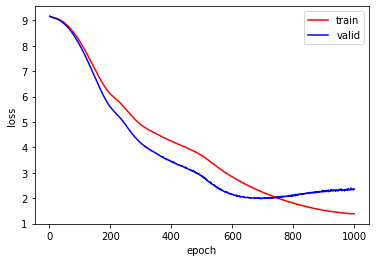

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

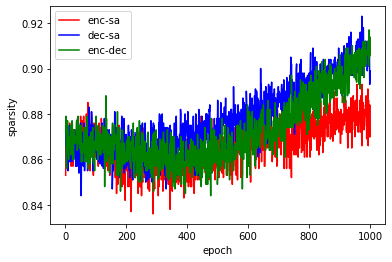

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')